In [27]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp
import jax
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM, LinearAutoregressiveHMM

import os
import glob
import h5py

In [77]:
#utils
def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data, subjects

def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors

In [29]:
# Load the data
data_root = "/home/zenari/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "task*.h5"
data, subjects = load_fmri(data_root, file_filter)

In [35]:
print('Number of fMRI:', len(subjects))
print('Shape of example fMRI:', data[0].shape)

Number of fMRI: 1630
Shape of example fMRI: (434, 488)


In [68]:
# Filtered list containing only elements with the expected shape
expected_shape = (434, 488)


print('Initial number of fMRI:', len(data))
data_cleaned = [sub for sub in data if sub.shape == expected_shape]
print('Final number of fMRI:', len(data_cleaned))

Initial number of fMRI: 1630
Final number of fMRI: 949


In [72]:
#Subsampling the data
n = 10 #number of fMRI
n_sample = np.random.randint(0, len(data_cleaned), n)

data_sub = [data_cleaned[i] for i in n_sample]

data_sub = np.array(data_sub)

data_sub.shape

In [74]:
#Zscore the data
data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data_sub
    ])    

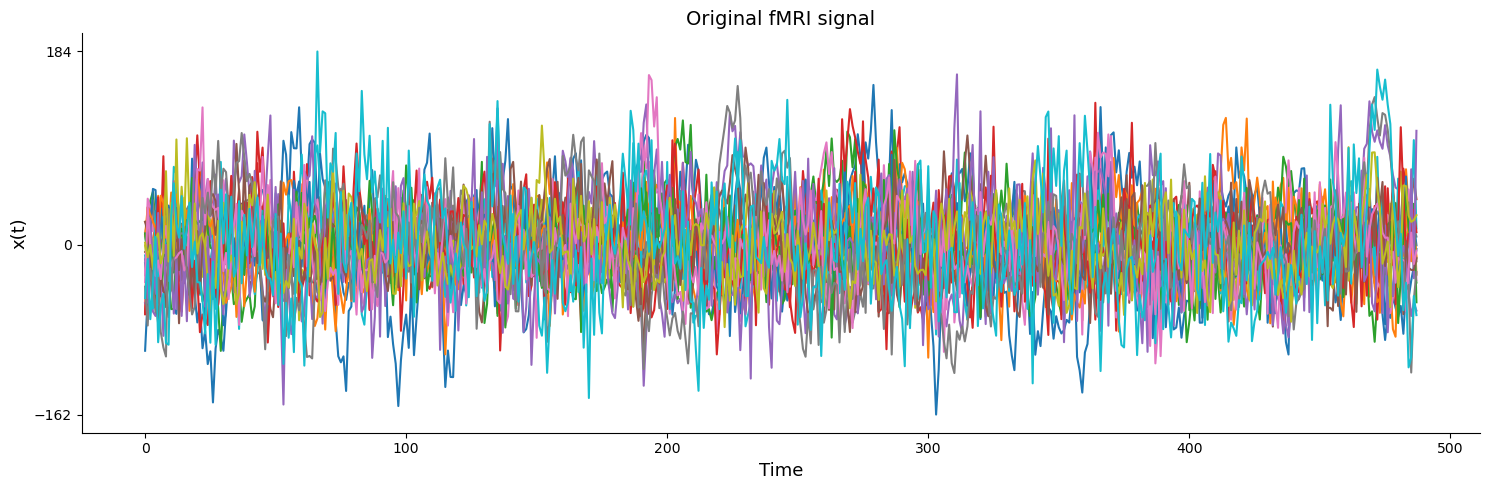

In [81]:
#plotting original sample
k = np.random.randint(0, n)
plot_signals(data_sub[k].T, dt = 1, n_plot=20, n_parcels=data_sub[k].shape[1], title='Original fMRI signal', figsize=(15, 5))

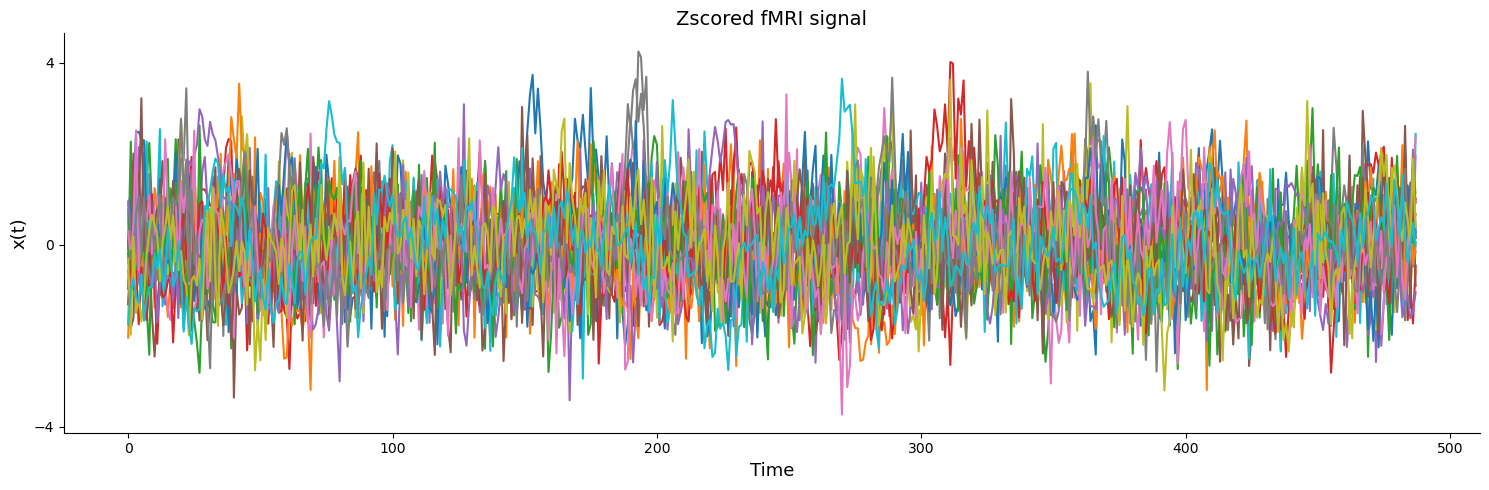

In [82]:
#plotting zscored sample  
plot_signals(data_zsc[k].T, dt = 1, n_plot=20, n_parcels=data_zsc[k].shape[1], title='Zscored fMRI signal', figsize=(15, 5))

## HMM

In [ ]:
data = np.array( [array for array in data if array.shape[1]==493] )   

bold_data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data
    ])     

concatenated_data = bold_data_zsc.transpose(1, 0, 2)
concatenated_data = concatenated_data.reshape(434, -1)
concatenated_data.shape